## tiff2nc-WISE
- Created by Will Wieder
- March 2022

### Converts geoTiff file from WISE to .nc files for use in mksurf

Combines gridded map units at 30sec resolution (1km) with Lookup table with soil properties.

Lookup table has 3 coordinates: 
- Map units that correspond to the gridded maps, which have information from 
- Multiple soil profiles (ranked in order of abundance), each with 
- Depth resolved properties, 7 vertical layers (0-2m depth)

#### Data available at [isric website](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc/formatters/xsl-view?root=div&view=advanced&approved=true)


retrieved with the following command:

`wget https://files.isric.org/public/wise/wise_30sec_v1.zip `

Finally, information about units & conversions for each variable are here: 
- Batjes NH 2016. Harmonised soil property values for broad-scale modelling (WISE30sec) with estimates of global soil carbon stocks. [Geoderma 2016(269), 61-68](http://dx.doi.org/10.1016/j.geoderma.2016.01.034) and
- Technical documentation [provided here](https://library.wur.nl/WebQuery/wurpubs/fulltext/400244)

The last plotting cell overloads memory, even using dask workers, as below.

Instead, getting 100GB of memory seems through JupyterHub seems to work.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import h5netcdf
#from affine import Affine
import matplotlib.pyplot as plt
from glob import glob
import dask
from distributed import wait
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

%matplotlib inline

## point to raw datasets

In [2]:
path ='/glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/'
infile = path + 'wise_30sec_v1.tif'
Lookup = path + 'HW30s_FULL.txt'

In [3]:
lookup = pd.read_csv(Lookup, sep=',')
print('Lookup unique profiles = ' + str(len(lookup.NEWSUID.unique()) ) )
lookup.where(lookup.NEWSUID == 'WD10001666').dropna().head()

Lookup unique profiles = 16413


,NEWSUID,SCID,PROP,CLAF,PRID,Drain,DrainNum,Layer,TopDep,BotDep,...,ESP,ESP_std,PHAQ,PHAQ_std,TCEQ,TCEQ_std,GYPS,GYPS_std,ELCO,ELCO_std
0,WD10001666,1.0,70.0,RGe,RGe/A,S,6.0,D2,20.0,40.0,...,4.0,3.0,6.4,0.6,0.0,0.0,29.0,33.0,1.0,1.0
193,WD10001666,1.0,70.0,RGe,RGe/A,S,6.0,D3,40.0,60.0,...,4.0,3.0,6.5,0.6,0.0,0.0,6.0,7.0,1.0,1.3
155698,WD10001666,2.0,30.0,LPq,LPq/A,E,7.0,D1,0.0,20.0,...,3.0,2.0,6.7,1.3,0.0,0.0,3.0,6.0,1.0,1.0
156294,WD10001666,2.0,30.0,LPq,LPq/A,-7,-9.0,D2,20.0,40.0,...,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0
156890,WD10001666,2.0,30.0,LPq,LPq/A,-7,-9.0,D3,40.0,60.0,...,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0


### Each mapping unit may have information about multiple profiles 
- this example has 2

In [4]:
# Drop characters off the front of map units and conver to intiger
lookup['MapUnit'] = (lookup.NEWSUID.str[4:]).astype(int)
print(lookup['MapUnit'].unique())
print(len(lookup['MapUnit'].unique()))

[ 1666  6309  1700 ...  7230  6997 32091]
16413


In [5]:
# convert to multi index and then create xarray dataset
lookup = lookup.set_index(['MapUnit','SCID','BotDep']).sort_index()
dsLook = lookup.to_xarray()
#dsLook

In [6]:
# Convert to Xarray dataset for mapping to CLM structures
# add meta data from Appendix 9 of technical documentation 
dsLook = lookup.to_xarray()
dsLook.MapUnit.attrs['long_name'] = 'WISE mapping unit'
dsLook.NEWSUID.attrs['long_name'] = 'Globally unique map unit code, see Appendix 4'
dsLook.SCID.attrs['long_name'] = 'Number of soil unit within the given map unit (ranges from 1 to 10)'
dsLook.PRID.attrs['long_name'] = 'profile ID (as documented in table HW30S_MapUnit, see Appendix 6)'
dsLook.Drain.attrs['long_name'] = 'FAO soil drainage class'
dsLook.TopDep.attrs['long_name']  = 'depth of top of layer'
dsLook.TopDep.attrs['units'] = 'cm'
dsLook.BotDep.attrs['long_name'] = 'depth of bottom of layer'
dsLook.BotDep.attrs['units'] = 'cm'
dsLook.CFRAG.attrs['long_name'] = 'coarse fragments'
dsLook.CFRAG.attrs['units'] = 'vol% > 2 mm'

dsLook.SDTO.attrs['long_name'] = 'sand'
dsLook.SDTO.attrs['units']  = 'mass %'
dsLook.STPC.attrs['long_name'] = 'silt'
dsLook.STPC.attrs['units']  = 'mass %'
dsLook.CLPC.attrs['long_name'] = 'clay'
dsLook.CLPC.attrs['units']  = 'mass %'
dsLook.BULK.attrs['long_name'] = 'bulk density'
dsLook.BULK.attrs['units']  = '(kg dm^-3, g cm^-3'
dsLook.TAWC.attrs['long_name'] = 'available water capacity (-33 to -1500 kPa conform to USDA standards)'
dsLook.TAWC.attrs['units'] = 'cm m^-1'

dsLook.CECS.attrs['long_name'] = 'cation exchange capacity for fine earth fraction'
dsLook.CECS.attrs['units'] = 'cmol_c kg^-1'
dsLook.CECc.attrs['long_name'] = 'CECclay, corrected for contribution of organic matter'
dsLook.CECc.attrs['units'] = 'cmol_c kg^-1'
dsLook.TEB.attrs['long_name'] = 'total exchangeable bases'
dsLook.TEB.attrs['units'] = 'cmol_c kg^-1'
dsLook.BSAT.attrs['long_name'] = 'Base saturation as percentage of CECsoil'
dsLook.BSAT.attrs['units'] = 'None'
dsLook.ECEC.attrs['long_name'] = 'effective CEC'
dsLook.ECEC.attrs['units'] = 'cmol_c kg^-1'

dsLook.PHAQ.attrs['long_name'] = 'pH measured in water'
dsLook.PHAQ.attrs['units'] = 'None'
dsLook.TCEQ.attrs['long_name'] = 'total carbonate equivalent'
dsLook.TCEQ.attrs['units'] = 'gC kg^-1'
dsLook.ORGC.attrs['long_name'] = 'organic carbon content'
dsLook.ORGC.attrs['units'] = 'gC kg^-1'
dsLook.TOTN.attrs['long_name'] = 'total nitrogen'
dsLook.TOTN.attrs['units'] = 'gN kg^-1'
dsLook.CNrt.attrs['long_name'] = 'C/N ratio'
dsLook.CNrt.attrs['units'] = 'None'

dsLook.attrs['source data'] = 'https://files.isric.org/public/wise/wise_30sec_v1.zip'
dsLook.attrs['doucmentation'] = 'https://library.wur.nl/WebQuery/wurpubs/fulltext/400244'
dsLook.attrs['publication'] = 'https://doi.org/10.1016/j.geoderma.2016.01.034'
dsLook.attrs['accessed'] = '11 March, 2022'
dsLook.attrs['notes'] = 'generated by Will Wieder'
dsLook.attrs['source code'] = 'tiff2nc-WISE.ipynb'

[0.0175 0.0451 0.0906 0.1656 0.2892 0.493  0.829  1.3829 2.2962 3.4332]
[0.2 0.4 0.6 0.8 1.  1.5 2. ]


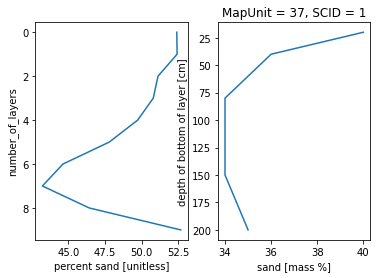

In [7]:
## Open file with target dimensions for CLM
CLMin = '/glade/p/cesmdata/cseg/inputdata/lnd/clm2/rawdata/mksrf_soitex.10level.c010119.nc'
dsCLM = xr.open_dataset(CLMin)
print(dsCLM.ZSOI.values)
print((dsLook.BotDep/100).values[0:7])
plt.subplot(1,2,1)
dsCLM.PCT_SAND.sel(max_value_mapunit=37).plot(y='number_of_layers') 
plt.gca().invert_yaxis();
plt.subplot(1,2,2)
dsLook.SDTO.isel(MapUnit = 2, SCID=0).plot(y='BotDep')
plt.gca().invert_yaxis();

- CLM layers 0-3 (<0.16) are 0-20 cm for WISE [0]
- CLM layer 4 (0.29) is 20-40 cm for WISE
- CLM layer 5 (0.49) is 40-60 cm for WISE
* no CLM layer for WISE data 60-80
- CLM layer 6 (0.83) is 80-100 cm for WISE
- CLM layer 7 (1.38) is 100-150 cm for WISE
- CLM layers 8-9 are 150-200 cm for WISE
#### make a new output datset with 10 layers, cooresponding to CLM layers


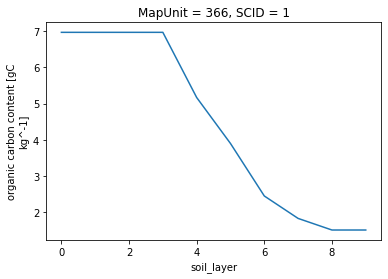

In [8]:
MapUnit = dsLook.MapUnit
SCID = dsLook.SCID
soil_layer = dsCLM.number_of_layers.rename({'number_of_layers':'soil_layer'})
#dsOUT = xr.Dataset(data_vars=None,
#                   coords=({'MapUnit' : MapUnit,    
#                            'SCID': SCID,
#                            'soil_layer': soil_layer}) )
temp0 = dsLook.rename({'BotDep': 'soil_layer'})
## leaving out PRID and DRAIN, as these don't play nicely with scripts later on
var = ['CFRAG','SDTO','STPC','CLPC','BULK','TAWC',
       'CECS','CECc','TEB','BSAT','ECEC','PHAQ',
       'TCEQ','ORGC','TOTN','CNrt']
varType = ['int16','int16','int16','int16','float32','int16',
           'float32','float32','float32','int16','float32','float32',
           'float32','float32','float32','float32']

for i in range(len(var)):
    # CLM layers 0:3 in CLM are in WISE layer 0
    temp = temp0[var[i]][:,:,0]
    tempMerge = xr.concat([temp,temp,temp,temp],dim='soil_layer')

    # CLM layer 4:5  in CLM are in WISE layer 1:2
    temp = temp0[var[i]][:,:,1:3]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # CLM layer 6:8  in CLM are in WISE layer 4:6
    temp = temp0[var[i]][:,:,4:]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # CLM layer 9  in CLM are in WISE layer 6
    temp = temp0[var[i]][:,:,6]
    tempMerge = xr.concat([tempMerge,temp],dim='soil_layer')

    # sete missing values to -999
    FillValue = -999.
    tempMerge = tempMerge.where(tempMerge>-10,FillValue)
    tempMerge.attrs['_FillValue'] = FillValue
    #tempMerge.attrs['missing_value'] = FillValue
    tempMerge = tempMerge.astype(varType[i])

    if i == 0:
        dsOUT = tempMerge.to_dataset(name=var[i])
    else:
        dsOUT[var[i]] = tempMerge

# switch to CLM soil layer convention
dsOUT['soil_layer'] = soil_layer
dsOUT['ORGC'].isel(MapUnit=100,SCID=0).plot() ; 
dsOUT.attrs = dsLook.attrs
dsOUT['ZSOI'] = dsCLM.ZSOI.rename({'number_of_layers':'soil_layer'})
dsOUT['DZSOI']= dsCLM.DZSOI.rename({'number_of_layers':'soil_layer'})
dsOUT['ZSOI'].attrs['_FillValue'] = -1e36
dsOUT['DZSOI'].attrs['_FillValue'] = -1e36
dsOUT = dsOUT.transpose("MapUnit", "SCID", "soil_layer")
dsOUT = dsOUT.rename({'SDTO':'PCT_SAND',
                      'STPC':'PCT_SILT',
                      'CLPC':'PCT_CLAY',
                     })

*Notes from Appendix 7:* A minus 8 indicates that no meaningful substitution was possible for the specified ‘soil unit/climate’ cluster and attribute
using TTR based on the present selection of soil profiles, -1 is used for Oceans and inland waters, -2 for Glaciers and snow caps,
-3 for rock outcrops (resp. -7 for ‘rocky’ subsoils as for Leptosols), -4 for Dunes/Shifting sands, -5 for Salt flats, and -9 for all
remaining miscellaneous units mainly to facilitate visualization using GIS.

- For purposes of generating the soil properties needed in CLM do we need to just extend values from the bottom layer that's not missing 

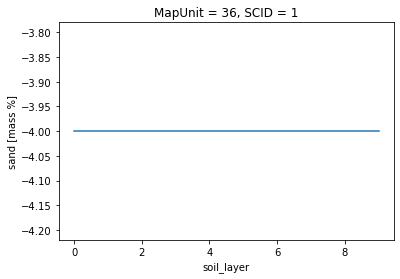

In [9]:
dsOUT['PCT_SAND'].isel(MapUnit=1,SCID=0).plot() ; 
#dsOUT

In [10]:
## Write out .nc file
fout = path + 'wise_30sec_v1_lookup.nc'
dsOUT.to_netcdf(fout, engine="netcdf4", format='NETCDF3_64BIT',
                encoding={'soil_layer': {'dtype': 'i4'},
                          'MapUnit' : {'dtype': 'i4'},
                          'SCID': {'dtype': 'i4'},
                          'PCT_SAND': {'dtype': 'i4'},
                          'PCT_SILT': {'dtype': 'i4'},
                          'PCT_CLAY': {'dtype': 'i4'},
                          'CFRAG': {'dtype': 'i4'},
                          'TAWC': {'dtype': 'i4'},
                          'BSAT': {'dtype': 'i4'},
                         })
print('wrote '+fout)

wrote /glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/wise_30sec_v1_lookup.nc


Then manually set to .nc5?  
`nccopy -k cdf5 /glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/wise_30sec_v1_lookup.nc /glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/wise_30sec_v1_lookup2.nc`

## open .tif as rioxarray to bring in meta and projection data

In [11]:
#with dask.config.set(**{'array.slicing.split_large_chunks': True}):
rds = rioxarray.open_rasterio(infile)
rds = rds.rename({'x': 'lon','y': 'lat'})
rds = rds.isel(band=0).to_dataset(name='MU')
rds = rds.reset_coords(names=['spatial_ref','band'], drop=True)
rds['MU'] = rds['MU'].astype(int)
FillValue = 0
rds['MU'] = rds['MU'].where(rds['MU']>0, FillValue)
rds['MU'].attrs['_FillValue'] = FillValue
rds = rds.load()
rds = rds.isel(lon=slice(0,-1)) # remove last (extra?) lat value (>180 E)
#_ = wait(rds)

In [12]:
## Check to see that dimensions are the same for lookup table and grid
df  = rds.to_dataframe()
df['MU'] = df.MU.astype('int').where(df.MU>0, FillValue)
df.MU.attrs['_FillValue'] = FillValue
print('gridded unique profiles = ' + str(len(df.MU.unique()) ) )
print('Lookup unique profiles = ' + str(len(dsOUT.MapUnit) ) )
print(' -- grid has extra value for missing data, ocean -- ')

gridded unique profiles = 16414
Lookup unique profiles = 16413
 -- grid has extra value for missing data, ocean -- 


In [13]:
print('min mapunit lookup = '+str(dsOUT['MapUnit'].values.min())+', grid ='+str(df.MU.min()) )
print('max mapunit lookup = '+str(dsOUT['MapUnit'].values.max())+', grid ='+str(df.MU.max()) )

min mapunit lookup = 2, grid =0
max mapunit lookup = 32156, grid =32156


In [14]:
rds.MU.attrs['long_name']= 'WISE30sec MapUnit'
rds.attrs = dsOUT.attrs

latmin  = rds.lon.min().values
latmax  = rds.lon.max().values
print('lat min-max ' +str(latmin) +", "+str(latmax))


lat min-max -179.99583333335, 179.99583189335004


In [15]:
lon = rds.lon.values
lon_diff = lon[1:None] - lon[0:-1]
lon_diff = np.append(lon_diff, np.mean(lon_diff))

lat = rds.lat.values
lat_diff = lat[1:None] - lat[0:-1]
lat_diff = np.append(lat_diff, np.mean(lat_diff))
lat_diff

# create data arrays for _bnds
bound = [0,1]
lon_bnds = xr.DataArray(dims = ['lon','bound'],
                        coords=dict(lon=lon, bound=bound),
                        name='lon_bnds')

lat_bnds = xr.DataArray(dims = ['lat','bound'],
                        coords=dict(lat=lat, bound=bound),
                        name='lat_bnds')

lon_bnds[:,0] = lon - lon_diff*0.5
lon_bnds[:,1] = lon + lon_diff*0.5
lat_bnds[:,0] = lat - lat_diff*0.5
lat_bnds[:,1] = lat + lat_diff*0.5


## prevent values > 180 and < -180
print(lon_bnds.max().values)
print(lon_bnds.min().values)
lon_bnds = lon_bnds.where(lon_bnds< 180, lon_bnds-360)
lon_bnds = lon_bnds.where(lon_bnds>-180, lon_bnds+360)
print(lon_bnds.max().values)
print(lon_bnds.min().values)


rds['lon_bnds']  = lon_bnds
rds['lat_bnds']  = lat_bnds

rds.lat.attrs['long_name']= 'latitude'
rds.lat.attrs['standard_name']= 'latitude'
rds.lat.attrs['units']= 'degrees_north'
rds.lat.attrs['bounds'] = 'lat_bnds'

rds.lon.attrs['long_name']= 'longitude'
rds.lon.attrs['standard_name']= 'longitude'
rds.lon.attrs['units']= 'degrees_east'
rds.lon.attrs['bounds'] = 'lon_bnds'
#print(rds['lon_bnds'].max().values)
#print(rds['lon_bnds'].min().values)

rds

179.99999856000005
-180.0
180.0
-179.9916666667


<xarray.Dataset>
Dimensions:   (lon: 43200, lat: 16753, bound: 2)
Coordinates:
  * lon       (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat       (lat) float64 83.62 83.61 83.6 83.6 ... -55.96 -55.97 -55.98
  * bound     (bound) int64 0 1
Data variables:
    MU        (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    lon_bnds  (lon, bound) float64 180.0 -180.0 -180.0 ... 180.0 180.0 180.0
    lat_bnds  (lat, bound) float64 83.62 83.62 83.62 ... -55.98 -55.98 -55.98
Attributes:
    source data:    https://files.isric.org/public/wise/wise_30sec_v1.zip
    doucmentation:  https://library.wur.nl/WebQuery/wurpubs/fulltext/400244
    publication:    https://doi.org/10.1016/j.geoderma.2016.01.034
    accessed:       11 March, 2022
    notes:          generated by Will Wieder
    source code:    tiff2nc-WISE.ipynb

In [16]:
print('lon [0] = '+ 
      str(rds['lon'].isel(lon=0).values) +
      ', [-2] = '+
      str(rds['lon'].isel(lon=-2).values))

print()
      
print('lon_bnds [0,0] = '+ 
      str(rds['lon_bnds'].isel(lon=0,bound=0).values) +
      ', [-2,1] = '+
      str(rds['lon_bnds'].isel(lon=-2,bound=1).values) )

print()

print('spacing between lons = '+str(lon_diff.max()) )

lon [0] = -179.99583333335, [-2] = 179.98749856005003

lon_bnds [0,0] = 180.0, [-2,1] = 179.99166522670004

spacing between lons = 0.00833333330001551


In [17]:
# Add additional metadata for coordinates
rds.lat.attrs['_FillValue'] = 1e-36
rds.lon.attrs['_FillValue'] = 1e-36
rds.lat_bnds.attrs['_FillValue'] = 1e-36
rds.lon_bnds.attrs['_FillValue'] = 1e-36

In [18]:
## Write out .nc file
fout = path + 'wise_30sec_v1_grid.nc'
rds.to_netcdf(fout, engine="h5netcdf",
              encoding={'MU': {'dtype': 'i4'},
                        'bound' : {'dtype': 'i4'}, 
                       })
print('wrote '+fout)

wrote /glade/scratch/wwieder/wise_30sec_v1/WISE30sec/Interchangeable_format/wise_30sec_v1_grid.nc


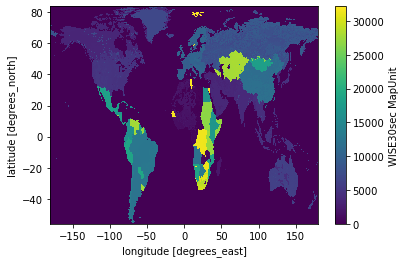

In [19]:
# This takes forver, or overloads memory
rds.MU.plot() ;

-------

In [20]:
# https://github.com/rasbt/watermark
%load_ext watermark
%watermark --updated --date --iversions --gitrepo --gitbranch --githash --python

Last updated: 2022-04-02

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 7.31.1

Git hash: 65351ae76ece1f0411708706f40d9af139179556

Git repo: git@github.com:wwieder/ctsm_py.git

Git branch: master

rioxarray : 0.8.0
numpy     : 1.21.5
pandas    : 1.3.5
matplotlib: 3.5.1
xarray    : 0.20.2
dask      : 2021.10.0
sys       : 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]
json      : 2.0.9
h5netcdf  : 0.0.0



In [21]:
rds.MU

<xarray.DataArray 'MU' (lat: 16753, lon: 43200)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 83.62 83.61 83.6 83.6 ... -55.95 -55.96 -55.97 -55.98
Attributes:
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     WISE30sec MapUnit